In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import (
    plot_frequency_recency_matrix,
    plot_probability_alive_matrix,
    plot_period_transactions,
    plot_calibration_purchases_vs_holdout_purchases,
    plot_transaction_rate_heterogeneity,
    plot_dropout_rate_heterogeneity,
    plot_expected_repeat_purchases,
    plot_history_alive,
    plot_cumulative_transactions,
    plot_incremental_transactions
)
from lifetimes.utils import (
    summary_data_from_transaction_data,
    calibration_and_holdout_data,
    calculate_alive_path,
    expected_cumulative_transactions
)
from tqdm import tqdm

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Setting visualisation themes
sns.set(style="whitegrid")

# Load and preprocess data
df = pd.read_csv("data/Online_Retail.txt", sep='\t')
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"]).dt.date
df=df[df['TotalPrice']>0]
# Display the first few rows to understand the dataset structure
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01,1.25,13085,United Kingdom,30.0


In [2]:
# Exploring the date range of transactions
print("Latest date:", df['InvoiceDate'].max())
print("Earliest date:", df['InvoiceDate'].min())

Latest date: 2011-12-04
Earliest date: 2009-12-01


In [3]:
# RFM Analysis
data = summary_data_from_transaction_data(
    df, 'Customer ID', 'InvoiceDate',
    monetary_value_col='TotalPrice',
    observation_period_end=df['InvoiceDate'].max(),
    freq='D'
)
# retain only those customers that generate revenue
data.head()

,frequency,recency,T,monetary_value
Customer ID,,,,
12346,7.0,400.0,720.0,11066.637143
12347,6.0,365.0,399.0,799.495000
12348,4.0,363.0,433.0,449.310000
12349,3.0,571.0,584.0,1120.056667
12350,0.0,0.0,305.0,0.000000


In [4]:
# Calculating RFM scores
data['Recency_score'] = pd.cut(data['recency'], 5, labels=[5,4,3,2,1])
data['Monetary_score'] = pd.cut(data['monetary_value'], 5, labels=[1,2,3,4,5])
data['Frequency_score'] = pd.cut(data["frequency"].rank(method="first"), 5, labels=[1,2,3,4,5])
data['RFM_Score'] = (data['Recency_score'].astype(str) + data['Frequency_score'].astype(str))

# Segment mapping
seg_map = {
    '[1-2][1-2]': 'hibernating',
    '[1-2][3-4]': 'at_risk',
    '[1-2]5': 'can\'t_lose',
    '3[1-2]': 'about_to_sleep',
    '33': 'need_attention',
    '[3-4][4-5]': 'loyal_customers',
    '41': 'promising',
    '51': 'new_customers',
    '[4-5][2-3]': 'potential_loyalists',
    '5[4-5]': 'champions'
}
data['Segment'] = data['RFM_Score'].replace(seg_map, regex=True)
# Customer segmentation based on predicted purchases
print(data['Segment'].value_counts())

potential_loyalists    1704
new_customers          1172
can't_lose              971
at_risk                 762
loyal_customers         680
need_attention          287
champions               123
about_to_sleep          119
hibernating              42
Name: Segment, dtype: int64


In [5]:
# Fitting the BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 5860 subjects, a: 0.12, alpha: 64.26, b: 2.53, r: 0.67>


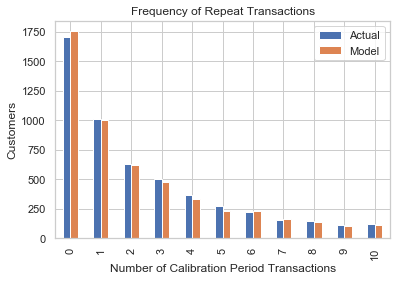

In [6]:
# Evaluating model fit
# Calibration period histogram - does the model fit the training data?
plot_period_transactions(bgf,max_frequency=11)

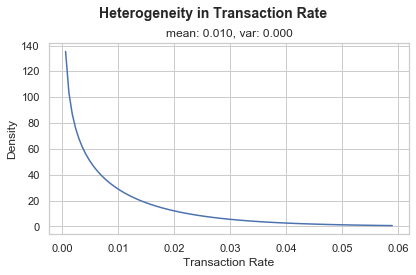

In [7]:
# plot the estimated gamma distribution of λ (customers' propensities to purchase)
plot_transaction_rate_heterogeneity(bgf);

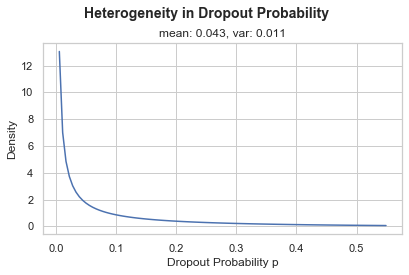

In [8]:
# plot the estimated beta distribution of p, a customers' probability of dropping out immediately after a transaction
plot_dropout_rate_heterogeneity(bgf);

In [9]:
# Cross-validation
summary_cal_holdout = calibration_and_holdout_data(df, 'Customer ID', 
                                                   'InvoiceDate',
                                                   calibration_period_end='2011-05-04',
                                                   observation_period_end='2011-12-04',
                                                   freq = 'D')
print(summary_cal_holdout.head())
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])

             frequency_cal  recency_cal  T_cal  frequency_holdout  \
Customer ID                                                         
12346                  7.0        400.0  506.0                0.0   
12347                  3.0        158.0  185.0                3.0   
12348                  3.0        190.0  219.0                1.0   
12349                  2.0        182.0  370.0                1.0   
12350                  0.0          0.0   91.0                0.0   

             duration_holdout  
Customer ID                    
12346                   214.0  
12347                   214.0  
12348                   214.0  
12349                   214.0  
12350                   214.0  


<lifetimes.BetaGeoFitter: fitted with 4835 subjects, a: 0.15, alpha: 67.29, b: 3.53, r: 0.69>

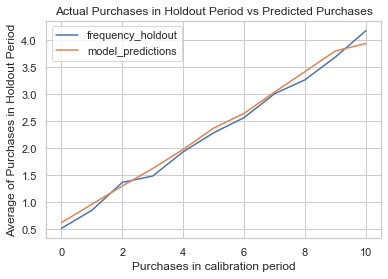

In [10]:
# Conditional expectations plot - can the model predict the number of purchases a customer will make based on the 
# training data?
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout,kind="frequency_cal",n=11)

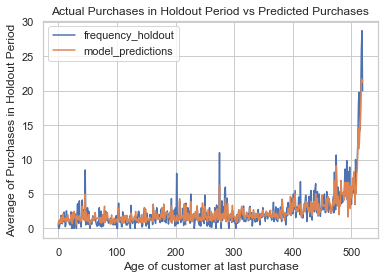

In [11]:
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout,kind="recency_cal",n=550)

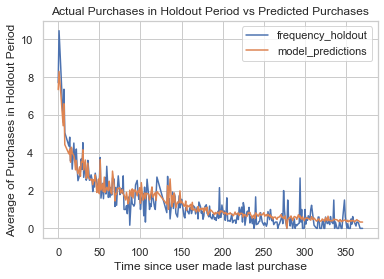

In [12]:
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout,kind="time_since_last_purchase",n=300)

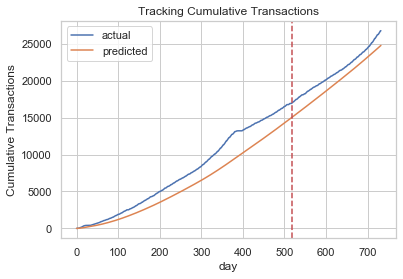

In [13]:
# Cumulative transaction plot - does the model predict cumulative sales well?
plot_cumulative_transactions(bgf, df, 'InvoiceDate', 'Customer ID', 733, 519, freq='D')

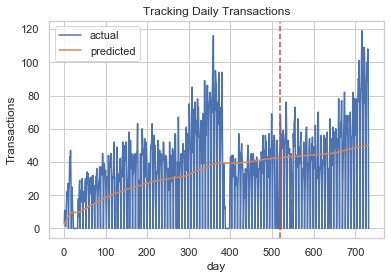

In [14]:
# Incremental transaction plot - does the model capture the overall trend in transactions?
plot_incremental_transactions(bgf, df, 'InvoiceDate', 'Customer ID', 733, 519, freq='D')

In [15]:
# Probability of being alive - estimating the likelihood that a customer will continue to make purchases after their last observed transaction in the data
data['prob_alive'] = bgf.conditional_probability_alive(data['frequency'], data['recency'], data['T'])
#data.head()
data[['prob_alive']].head()

,prob_alive
Customer ID,
12346,0.532411
12347,0.971397
12348,0.955108
12349,0.971372
12350,1.000000


In [16]:
# Expected number of purchases/transactions up to time
t = 31*3 # The number of time periods
data['predicted_purchases_3_months'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
#data.head()
data[['predicted_purchases_3_months']].head()

,predicted_purchases_3_months
Customer ID,
12346,0.480423
12347,1.282021
12348,0.824953
12349,0.508476
12350,0.171638


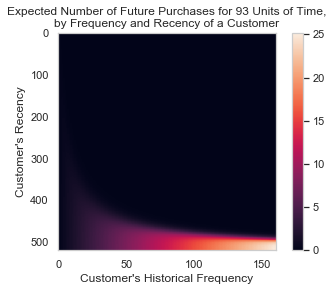

In [17]:
# Visualizing our frequency/recency matrix
T=31*3 # Time horizon for estimating number of purchases
plot_frequency_recency_matrix(bgf,T)
plt.grid(False)

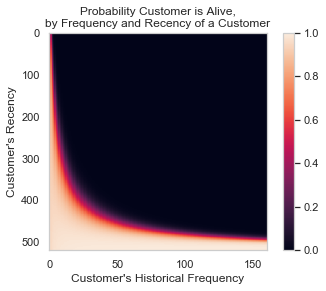

In [18]:
plot_probability_alive_matrix(bgf)
plt.grid(False)

In [19]:
# Function to plot the probability of being "alive" for a single customer
data=data.reset_index()
def plot_customer_alive_prob(customer_id, data, df, bgf, plots_display='OFF'):
    plt.clf()  # Clear any existing plots

    # Dynamically calculate days_since_birth based on the dataset's time span
    dataset_start_date = df['InvoiceDate'].min()
    dataset_end_date = df['InvoiceDate'].max()
    days_since_birth = (dataset_end_date - dataset_start_date).days

    # Extract metrics and transaction history for the specified customer
    trans_history = df.loc[df['Customer ID'] == customer_id]

    if plots_display == 'ON':
        plt.figure()
    
    alive_data = plot_history_alive(plots_display, bgf, days_since_birth, trans_history, 'InvoiceDate')
    df_prob_hist1 = pd.DataFrame(alive_data[1].tolist()).rename(columns={0: 'Date'})
    df_prob_hist2 = pd.DataFrame(alive_data[2].tolist()).rename(columns={0: 'p_alive'})
    purchase_date_list = alive_data[3]

    # Combine probability history into a single DataFrame
    df_prob_hist = pd.concat([df_prob_hist1, df_prob_hist2], axis=1)
    df_prob_hist['InvoiceDate'] = 0
    df_prob_hist.loc[df_prob_hist.Date.isin(purchase_date_list), 'InvoiceDate'] = 1
    df_prob_hist['Customer ID'] = customer_id

    # Append to the master DataFrame
    return df_prob_hist

,Date,p_alive,InvoiceDate,Customer ID
0,2010-10-31,1.000000,1,12347
1,2010-11-01,1.000000,0,12347
2,2010-11-02,1.000000,0,12347
3,2010-11-03,1.000000,0,12347
4,2010-11-04,1.000000,0,12347
...,...,...,...,...
729,2012-10-29,0.485887,0,12347
730,2012-10-30,0.483789,0,12347
731,2012-10-31,0.481694,0,12347
732,2012-11-01,0.479603,0,12347


<Figure size 432x288 with 0 Axes>

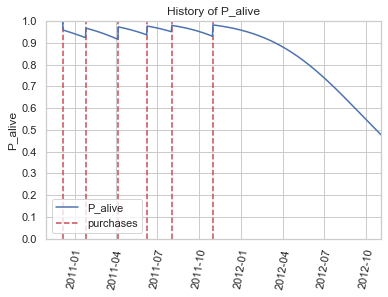

In [20]:
# Plotting the probability of being "alive" for a single customer
plot_customer_alive_prob(12347, data, df, bgf, plots_display='ON')

In [21]:
# Probability of being "alive" for all customers
df_p_alive = pd.DataFrame()
for customer_id in tqdm(data['Customer ID'].unique()):
    df_prob_hist = plot_customer_alive_prob(customer_id, data, df, bgf, plots_display='OFF')
    frames_final=[df_p_alive,df_prob_hist]
    df_p_alive=pd.concat(frames_final)

100%|██████████████████████████████████████████████████████████████████████████████| 5860/5860 [20:27<00:00,  4.78it/s]


<Figure size 432x288 with 0 Axes>

In [22]:
df_p_alive

,Date,p_alive,InvoiceDate,Customer ID
0,2009-12-14,1.000000,1,12346
1,2009-12-15,1.000000,0,12346
2,2009-12-16,1.000000,0,12346
3,2009-12-17,1.000000,0,12346
4,2009-12-18,0.958920,1,12346
...,...,...,...,...
729,2012-05-15,0.905574,0,18287
730,2012-05-16,0.904961,0,18287
731,2012-05-17,0.904345,0,18287
732,2012-05-18,0.903727,0,18287


In [23]:
# The Gamma-Gamma model and the independence assumption
returning_customers_summary = data[data['frequency']>0]
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.136451
frequency,0.136451,1.000000


In [24]:
# Gamma-Gamma model
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 4154 subjects, p: 2.12, q: 3.57, v: 497.64>


In [25]:
# Estimated average transaction value
ggf.conditional_expected_average_profit(data['frequency'],
                                        data['monetary_value']).sort_values(ascending=False)

3359    9953.060833
0       9491.906393
5674    9132.239050
5035    6671.206189
1530    6552.533511
           ...     
5393      94.199097
5465      93.000036
5562      73.341169
5609      45.245582
5535      41.454981
Length: 5860, dtype: float64

In [26]:
# The customers' lifetime values expected to in the next 3 months
data['cltv_pred_3_months'] = ggf.customer_lifetime_value(bgf,
                                   data['frequency'],
                                   data['recency'],
                                   data['T'],
                                   data['monetary_value'],
                                   time=90,  # 3 months
                                   freq="D",  # frequency information of T. In this case we set week by using 'W'
                                   discount_rate=0.01)
data.head()

,Customer ID,frequency,recency,T,monetary_value,Recency_score,Monetary_score,Frequency_score,RFM_Score,Segment,prob_alive,predicted_purchases_3_months,cltv_pred_3_months
0,12346,7.0,400.0,720.0,11066.637143,3,3,5,35,loyal_customers,0.532411,0.480423,78808.425659
1,12347,6.0,365.0,399.0,799.495000,3,1,4,34,loyal_customers,0.971397,1.282021,15715.357791
2,12348,4.0,363.0,433.0,449.310000,3,1,4,34,loyal_customers,0.955108,0.824953,6129.599746
3,12349,3.0,571.0,584.0,1120.056667,2,1,3,23,at_risk,0.971372,0.508476,8031.019395
4,12350,0.0,0.0,305.0,0.000000,5,1,1,51,new_customers,1.000000,0.171638,1210.088418


In [27]:
# Create segments for customer lifetime value
data['segment'] = pd.qcut(data['cltv_pred_3_months'],4,['D','C','B','A'])
data.head()

,Customer ID,frequency,recency,T,monetary_value,Recency_score,Monetary_score,Frequency_score,RFM_Score,Segment,prob_alive,predicted_purchases_3_months,cltv_pred_3_months,segment
0,12346,7.0,400.0,720.0,11066.637143,3,3,5,35,loyal_customers,0.532411,0.480423,78808.425659,A
1,12347,6.0,365.0,399.0,799.495000,3,1,4,34,loyal_customers,0.971397,1.282021,15715.357791,A
2,12348,4.0,363.0,433.0,449.310000,3,1,4,34,loyal_customers,0.955108,0.824953,6129.599746,A
3,12349,3.0,571.0,584.0,1120.056667,2,1,3,23,at_risk,0.971372,0.508476,8031.019395,A
4,12350,0.0,0.0,305.0,0.000000,5,1,1,51,new_customers,1.000000,0.171638,1210.088418,C
